In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

## Acquire 

#### Acquire the data by storing the contents of 'saas.csv' into a Pandas dataframe.

In [2]:
df = pd.read_csv('saas.csv')

In [4]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


## Takeaways
* I will have to convert 'Month_Invoiced' to a datetime datatype and set it as the index.


In [5]:
# Change 'Month_Invoiced' column into a datetime datatype.
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

In [6]:
# Set 'Month_Invoiced' as the index for the dataframe.
df = df.set_index('Month_Invoiced').sort_index()

In [7]:
df

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [8]:
len(df.Customer_Id.value_counts())

29400

## Takeaways
* There are 29400 different customers in this dataframe
* There are some invoices where there is a new 'Customer_Id' value, but both 'Subscription_Type' and 'Amount' have 0.0 values. I wonder what this means.
* These capital letters are annoying to deal with. I will change the names of the columns.

I will look at individual customers to see if I can find the reason for these 0.0 values. I'm guessing that the first month or two may be free for the new customer.

In [9]:
df.rename(columns={'Customer_Id':'customer','Invoice_Id':'invoice','Subscription_Type':'subscription','Amount':'amount'}, inplace=True)

In [10]:
df[df['customer'] == 1000000]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-02-28,1000000,5020000,0.0,0.0
2014-03-31,1000000,5039800,0.0,0.0
2014-04-30,1000000,5059399,0.0,0.0
2014-05-31,1000000,5078812,0.0,0.0
2014-06-30,1000000,5098033,0.0,0.0
2014-07-31,1000000,5117071,0.0,0.0
2014-08-31,1000000,5135922,0.0,0.0
2014-09-30,1000000,5154594,0.0,0.0


## Takeaways
* This customer got their first year free?

Let's look at a few more..

In [11]:
df[df['customer'] == 1000001]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000001,5000001,2.0,10.0
2014-02-28,1000001,5020001,2.0,10.0
2014-03-31,1000001,5039801,2.0,10.0
2014-04-30,1000001,5059400,2.0,10.0
2014-05-31,1000001,5078813,2.0,10.0
2014-06-30,1000001,5098034,2.0,10.0
2014-07-31,1000001,5117072,2.0,10.0
2014-08-31,1000001,5135923,2.0,10.0
2014-09-30,1000001,5154595,2.0,10.0


In [12]:
df[df['customer'] == 1000002]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000002,5000002,0.0,0.0
2014-02-28,1000002,5020002,1.0,5.0


In [13]:
df[df['customer'] == 1000003]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000003,5000003,0.0,0.0
2014-02-28,1000003,5020003,0.0,0.0
2014-03-31,1000003,5039802,0.0,0.0
2014-04-30,1000003,5059401,0.0,0.0
2014-05-31,1000003,5078814,0.0,0.0
2014-06-30,1000003,5098035,0.0,0.0
2014-07-31,1000003,5117073,0.0,0.0
2014-08-31,1000003,5135924,0.0,0.0
2014-09-30,1000003,5154596,0.0,0.0


In [14]:
df[df['customer'] == 1000004]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000004,5000004,1.0,5.0
2014-02-28,1000004,5020004,1.0,5.0
2014-03-31,1000004,5039803,1.0,5.0
2014-04-30,1000004,5059402,1.0,5.0
2014-05-31,1000004,5078815,1.0,5.0
2014-06-30,1000004,5098036,1.0,5.0
2014-07-31,1000004,5117074,1.0,5.0
2014-08-31,1000004,5135925,1.0,5.0
2014-09-30,1000004,5154597,1.0,5.0


In [15]:
df[df['customer'] == 1000006]

,customer,invoice,subscription,amount
Month_Invoiced,,,,
2014-01-31,1000006,5000006,0.0,0.0
2014-02-28,1000006,5020006,0.0,0.0
2014-03-31,1000006,5039805,0.0,0.0
2014-04-30,1000006,5059404,0.0,0.0
2014-05-31,1000006,5078817,0.0,0.0
2014-06-30,1000006,5098038,0.0,0.0
2014-07-31,1000006,5117076,0.0,0.0
2014-08-31,1000006,5135927,0.0,0.0
2014-09-30,1000006,5154599,0.0,0.0


## Takeaways
* There are some customers who have 1 year of no charges, there are some customers who have 2 years of no charges, there are some customers that have multiplie invoices with no charges, then invoices stop suddenly, and then there are some customers where their charges start immediately. 

I'm not sure what the situation is here without more information.


# For this exercise we will set the 'amount' as the target variable. We will then create a model that will be able to predict future revenue.

In [16]:
target = df.amount

### Let's plot the target variable over time.
We will first aggregate the amount by the date using sum(). We will then do a quick plot of this aggregated data.

<AxesSubplot:xlabel='Month_Invoiced'>

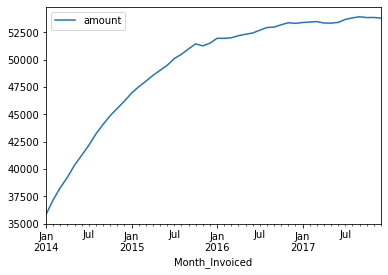

In [17]:
by_date = df.groupby(['Month_Invoiced']).amount.sum().reset_index()
by_date.plot(x='Month_Invoiced', y='amount')

## Takeaways
* The slope of the graph represents Δx/Δt where Δx is the change in amount and Δt is the change in time. Therefore, it is the rate of change of amount(money) with respect to time.
* The slope of the graph is reaching zero as time passes. Which means growth is slowing and the amount will eventually reach a constant value.


## We'll split the data and use four different methods to forecast.